# DAI Transcation Analysis 2021

We have compiled a dataset with all transactions from the year 2021 that are either direct transcations (calls to the smart contract) or that interacted with the smart contract directly.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import PercentFormatter
sns.set_theme(style="whitegrid", palette="muted")

DATASET = 'dai_tx_2021.csv'

df = pd.read_csv(DATASET)
df.sort_values(by='num_tx', ascending=False).head()

,address,num_tx,smart_contract,origin
810631,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,628137,True,UniswapV2Router02
1,0xe592427a0aece92de3edee1f18e0157c05861564,227225,True,SwapRouter
810025,0xd9e1ce17f2641f24ae83637ab66a2cca9c378b9f,218987,True,UniswapV2Router02
810369,0xa57bd00134b2850b2a1c55860c9e9ea100fdd6cf,152724,True,market_maker
4,0x503828976d22510aad0201ac7ec88293211d23da,140379,False,exchange


Within the dataset, there are by far more transactions then accounts.

In [2]:
total_accounts = df.shape[0]
total_transactions = df['num_tx'].sum()
f'Total accounts: {total_accounts} | Total transactions: {total_transactions}'

'Total accounts: 810755 | Total transactions: 5395801'

The ration of accounts to transcations it roughly 1:5.

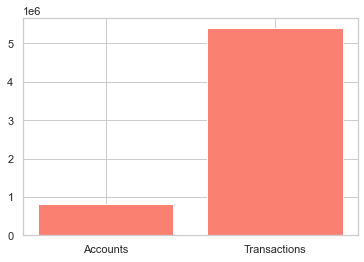

In [3]:
_ = plt.bar(['Accounts', 'Transactions'], [total_accounts, total_transactions], color="salmon")

### Descriptives of transactions by account


How does the above ratio translate into the activity per account over the full dataset?

We can describe by looking at key distribution parameters for this:

In [4]:
df['num_tx'].describe()

count    810755.000000
mean          6.655279
std         862.965753
min           1.000000
25%           1.000000
50%           1.000000
75%           2.000000
max      628137.000000
Name: num_tx, dtype: float64

1. There are about 800k addresses in total in the dataset
2. We can already see that the majority of addresses (see the 50% percentile at 1) only have one transaction in here. 
3. On average (mean) there are however >6 transactions per address. This is a first indicator of a skewed distribution.
4. The latter is further supported by the max value >600k, meaning one single address has this many transactions.

Visualizing such heavily skewed distributions is always a challenge. We therefore apply a log transform beforehand. 

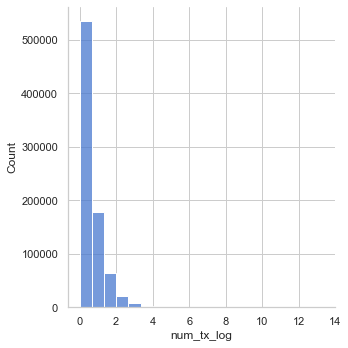

In [5]:
_ = sns.displot(
    df.assign(num_tx_log = df['num_tx'].apply(np.log)),
    x = 'num_tx_log',
    bins=20
)

In essence the number of transactions follows a stronly skewed distribution:

1. The majority of accounts have only one transaction
2. About 1/10 of transactions are done by these accounts which only have one transaction
3. There is a top group of accounts with a strong concentration of transactions. The largest single account also is responsible for about one quarter of the transactions.

We can also represent this "inverse" like relationship through **binning of the accounts by transactions**.

This can help us a bit more to understand the amount of transactions caused by accounts of different sizes. 
A consideration which is important for the classification into different categories.

The disambiguation of the background of larger accounts has a very good cost-to-benefit ratio as with one action one can classify tens of thousands of transactions.

In [28]:
bins = [0, 1, 10, 100, 1000, 10000, 1000000]
df['bins'] = pd.cut(df['num_tx'], bins)

binned = (
    df
    .groupby('bins')
    ['num_tx']
    .agg([len, np.sum])
)
binned.columns = ['n accounts', 'n transactions']

binned

,n accounts,n transactions
bins,,
"(0, 1]",535269,535269
"(1, 10]",255688,845210
"(10, 100]",18446,408180
"(100, 1000]",1082,309929
"(1000, 10000]",217,611943
"(10000, 1000000]",53,2685270


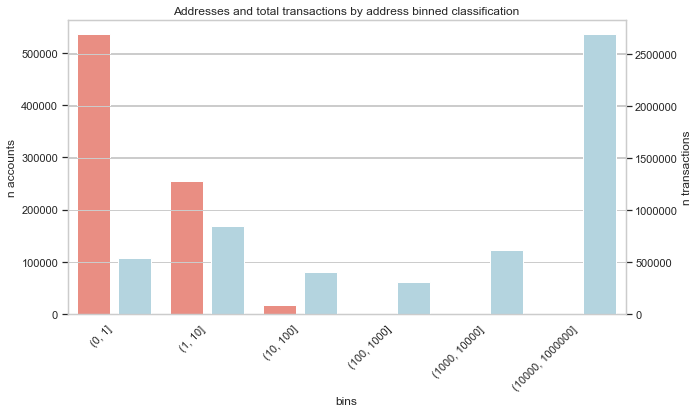

In [9]:
fig, ax1 = plt.subplots(figsize=(10,6))
sns.barplot(data = binned.reset_index(), x='bins', y='n accounts', ax=ax1, color="salmon")
width_scale = 0.45
for bar in ax1.containers[0]:
    bar.set_width(bar.get_width() * width_scale)

ax2 = ax1.twinx()
sns.barplot(data = binned.reset_index(), x='bins', y='n transactions', ax=ax2, color='lightblue')

for bar in ax2.containers[0]:
    x = bar.get_x()
    w = bar.get_width()
    bar.set_x(x + w * (1- width_scale))
    bar.set_width(w * width_scale)

plt.ticklabel_format(style='plain', axis='y')
_ = plt.title("Addresses and total transactions by address binned classification")

fig.autofmt_xdate(rotation=45)

## Differentiate by origin

The next way to classify addresses is by "origin" field. See `offchain_emissions.md` for it's exact definition. 

Here we group all adresses by origin. But first we have to get an idea of how many different values we can expect in origin:

In [10]:
df['origin'].nunique()

1322

This is obviously too many to look at individually.

In [11]:
origin = (
    df
    .groupby('origin')
    ['num_tx']
    .agg([len, np.sum])
)
origin.columns = ['n accounts', 'n transactions']

We start by looking at the top 10 (with regard to transactions) origin type.

In [12]:
origin.sort_values('n transactions', ascending=False).head(10)

,n accounts,n transactions
origin,,
wallet,768428,1578177
UniswapV2Router02,24,853757
exchange,59,768213
not_verifiable,585,376220
market_maker,40,301830
SwapRouter,1,227225
DSProxy,13037,111587
AggregationRouterV3,2,107337
ZeroEx,1,93859


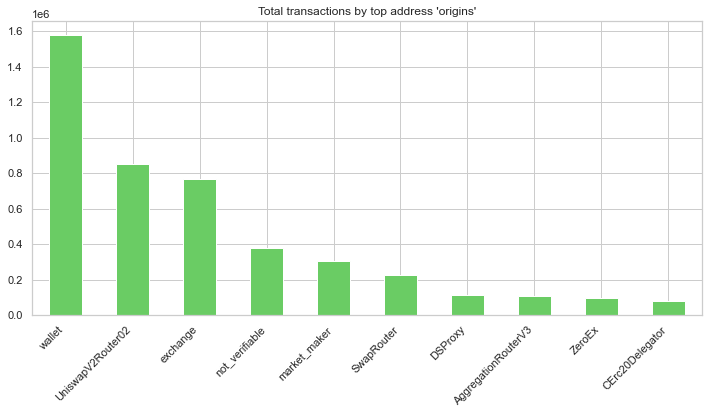

In [13]:
f, ax = plt.subplots()

origin.sort_values('n transactions', ascending=False).head(10)['n transactions'].plot(kind='bar', ax = ax, color='g', figsize=(12, 6))
f.autofmt_xdate(rotation=45)

x_axis = ax.xaxis
x_axis.label.set_visible(False)

_ = plt.title("Total transactions by top address 'origins'")

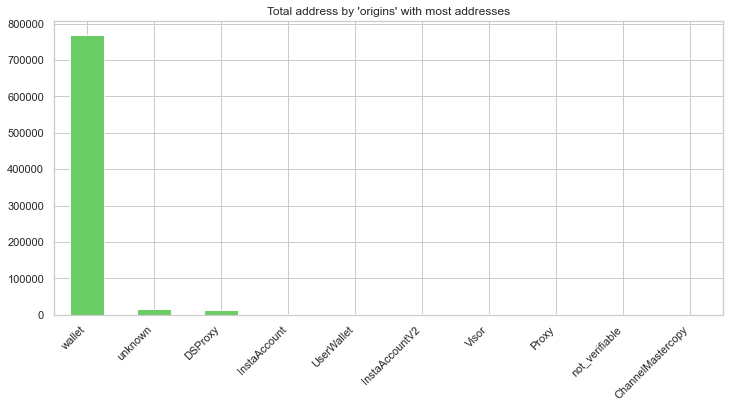

In [14]:
f, ax = plt.subplots()

origin.sort_values('n accounts', ascending=False).head(10)['n accounts'].plot(kind='bar', ax = ax, color='g', figsize=(12, 6))
f.autofmt_xdate(rotation=45)

x_axis = ax.xaxis
x_axis.label.set_visible(False)

_ = plt.title("Total address by 'origins' with most addresses")

"Wallet" is completely dominating the picture. Let's to the top 2-11, so effectively ommitting "wallet".

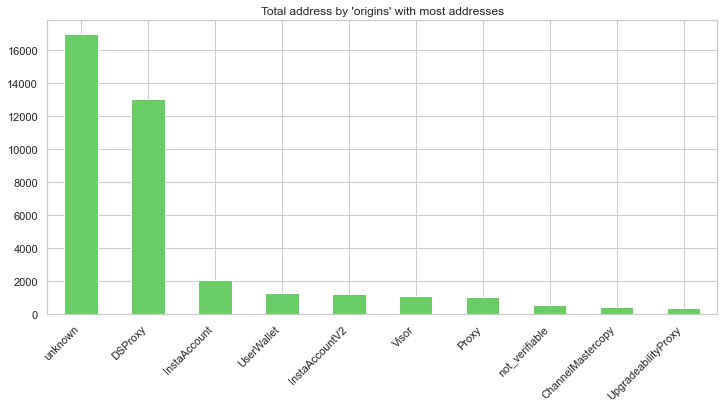

In [15]:
f, ax = plt.subplots()

origin.sort_values('n accounts', ascending=False).head(11).tail(10)['n accounts'].plot(kind='bar', ax = ax, color='g', figsize=(12, 6))
f.autofmt_xdate(rotation=45)

x_axis = ax.xaxis
x_axis.label.set_visible(False)

_ = plt.title("Total address by 'origins' with most addresses")

## Flagging footprint contributors 

This is done via a combined criteria of origin&smart contract fields

In [30]:
multisigs = ['MultiSigWalletWithDailyLimit', 'MultiSigWalletWithTimeLock', 'GnosisSafeProxy', 'multi_sig', 'DSProxy', 'Argent']

df['footprint_detail'] = np.where(
    (df['origin'].isin(multisigs)), 
    'Multisignature',
    np.where(
        ((df['origin'] == 'market_maker') & (~df['smart_contract'])),
        'Market Makers  (Non SmartContract)',
        np.where(
            (df['origin'] == 'exchange'),
            'Exchanges',
            np.where(
                (df['origin'] == 'not_verifiable'),
                'Not Verifiable',
                np.where(
                    (df['origin'] == 'unknown'),
                    'Unknown',
                    np.where(
                        (df['origin'] == 'wallet'),
                        'Wallet',
                        np.where(
                            ((df['origin'] == 'bridge') & (~df['smart_contract'])),
                            'Bridge (Non SmartContract)',
                            'NOT part of footprint to be offsetted'
                        )
                    )
                )
            )
        )
    )
)

footprint_detail = (
    df.query("footprint_detail != 'NOT part of footprint to be offsetted'")
    .groupby('footprint_detail')
    ['num_tx']
    .agg([len, np.sum])
)
footprint_detail.columns = ['n accounts', 'n transactions']

footprint_detail

,n accounts,n transactions
footprint_detail,,
Bridge (Non SmartContract),4,8333
Exchanges,59,768213
Market Makers (Non SmartContract),1,648
Multisignature,13279,129097
Not Verifiable,585,376220
Unknown,16938,55709
Wallet,768428,1578177


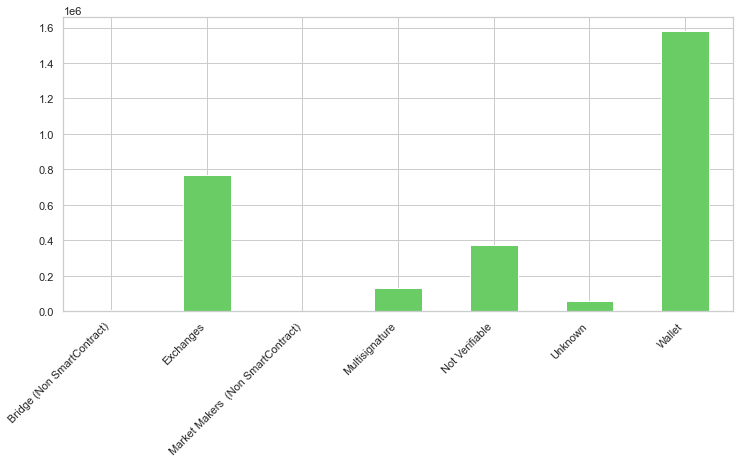

In [20]:
f, ax = plt.subplots()

footprint_detail['n transactions'].plot(kind='bar', ax = ax, color='g', figsize=(12, 6))
f.autofmt_xdate(rotation=45)

x_axis = ax.xaxis
x_axis.label.set_visible(False)

### All contributors

In [22]:
df['footprint'] = df['footprint_detail'] != 'NOT part of footprint to be offsetted'
footprint = (
    df
    .groupby('footprint')
    ['num_tx']
    .agg([len, np.sum])
)
footprint.columns = ['n accounts', 'n transactions']
footprint

We can see that we cover almost all (>98%) of accounts yet "only" >50% of transactions with this method.

This should be reflected in the distribution over the account size bins from above.

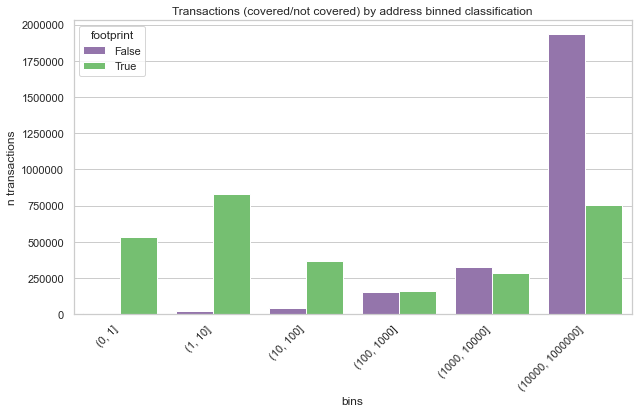

In [24]:
footprint_binned = (
    df
    .groupby(['footprint', 'bins'])
    ['num_tx']
    .agg([len, np.sum])
)
footprint_binned.columns = ['n accounts', 'n transactions']

fig, ax1 = plt.subplots(figsize=(10,6))
sns.barplot(data = footprint_binned.reset_index(), x='bins', y='n transactions', ax=ax1, hue='footprint', palette=["m", "g"])

plt.ticklabel_format(style='plain', axis='y')

_ = plt.title("Transactions (covered/not covered) by address binned classification")

fig.autofmt_xdate(rotation=45)

So we can see that that the footprint to be offsetted is nicely distributed across the different classes of "address bins".

Let's see how much of the footprint per address bin will be covered. Remember, overall roughly >50% will be covered.

In [25]:
fp_bin_cross = pd.pivot_table(
    df,
    columns='footprint',
    index='bins',
    values='num_tx',
    aggfunc=sum
)

fp_bin_cross = fp_bin_cross.divide(fp_bin_cross.sum(axis=1), axis=0)

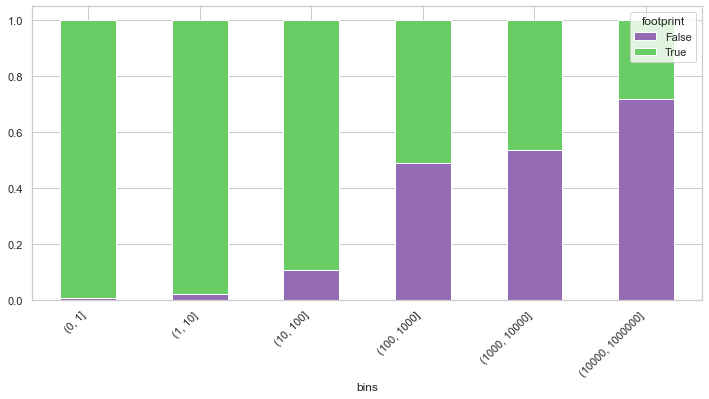

In [27]:
f, ax = plt.subplots()

_ = fp_bin_cross.plot(kind='bar', stacked=True, figsize=(12,6), color=["m", "g"], ax=ax)

f.autofmt_xdate(rotation=45)

Expectedly the share of coverable footprint is largest for small accounts. 

The larger the account or address the more likely it is a special setup therefore offsetting is to be handled in different ways.

# Summary

In total this will result in a footprint of `2916397` transactions to be subsetted